# Assignment 2

__41934 - Advanced BIM, E23__


Kaare G. S. Hansen, s214282 - DTU




BIM ideer:
- Byg etager oven på hindanden, forstør søjler etc...
- Ændre nyttelast i spaces, lav ny geometri, lav FEM-model
- Opennest, produktionstegninger

## Todo

- [ ] Bounding box to plane
- [ ] Project wall and slab to plane, generate mesh
- [ ] Beam/Column, lines, find common FEM-knots
- [ ] Connect wall/slab mesh to beam/columns
- [ ] Apply self-weight load
- [ ] Apply load from IfcSpaces/zones
- [ ] Create IfcStructuralAnalysisModel
- [ ] Analyse IfcStructuralAnalysisModel with PyNiteFEA
- [ ] Brug IFC-load method fra kursus

**Todo nu**:
- [ ] Plotly af guids
- [ ] Find samling af bjælker, søjler til udviklingseksempel
- [ ] Abstract base class til analyticalModel


**First step!** Just make MVP that barely works... Accuracy doesn't matter...

## Ideas
- Detect knots by end of beam/column lines
- Detect knots by enlarging obb slightly and doing checks..

## Limitations
- All analytical connections have zero DOF
- 

## Imports

In [1]:
import os
import sys
from collections import namedtuple
import numpy as np
import pandas as pd
import ifcopenshell
import ifcopenshell.util.placement
import ifcopenshell.geom
import ifcopenshell.util.shape
import ifcopenshell.util.selector

print(f"ifcopenshell version: {ifcopenshell.version}")
print(f"Python-version {sys.version}")

ifcopenshell version: 0.7.0
Python-version 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [2]:
from geomUtils import *
from ifcUtils import *
from rendering import *
import utils

In [3]:
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox
from OCC.Core.gp import gp_Pnt, gp_Ax2, gp_Dir, gp_XYZ
from OCC.Core.BRepBndLib import brepbndlib
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeVertex
from OCC.Core.Bnd import Bnd_OBB
from OCC.Core.BRepTools import breptools_Read
from OCC.Core.TopoDS import TopoDS_Shape
from OCC.Core.BRep import BRep_Builder
from OCC.Core.GC import GC_MakeArcOfCircle, GC_MakeSegment

from OCC.Display.SimpleGui import init_display
from OCC.Display.OCCViewer import rgb_color

from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Lin
from OCC.Core.Geom import Geom_Line, Geom_Point, Geom_CartesianPoint
from OCC.Core.AIS import AIS_Line, AIS_Point
from OCC.Core.Prs3d import Prs3d_LineAspect, Prs3d_Drawer
from OCC.Core.Quantity import Quantity_Color, Quantity_TOC_RGB

In [4]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
# pio.renderers.default = "png"
pio.renderers.default = "plotly_mimetype+png"

## Code

### Load models

In [5]:
models = load_models()

File path, ark: /Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\SkyLab/LLYN - ARK.ifc
Model schema: IFC4

File path, stru: /Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\SkyLab/LLYN - STRU.ifc
Model schema: IFC4



In [6]:
model = models['stru']
# model = models['ark']

### Load bearing elements

In [7]:
load_bearing = getLoadBearing(model)
len(load_bearing)

Number of load-bearing elements: 1750
Unique types of loadbearing elements:
 {'IfcColumn', 'IfcSlab', 'IfcWall', 'IfcBeam'}


1750

In [8]:
import OCC.Core
import OCC.Core.BRep
import OCC.Core.BRepPrimAPI
import OCC.Core.BRepTools

## Get IfcBeams as lines

In [9]:
bearingElements = dict()
for elm in load_bearing:
    key = elm.is_a()
    if not key in bearingElements:
        bearingElements[key] = list()
    
    bearingElements[key].append(elm)

[f"{key}: {len(val)}" for key, val in bearingElements.items()]

['IfcWall: 368', 'IfcSlab: 365', 'IfcBeam: 565', 'IfcColumn: 452']

In [10]:
settings = ifcopenshell.geom.settings()
settings.set(settings.USE_PYTHON_OPENCASCADE, True)  # tells ifcopenshell to use pythonocc

#################
# Extra options #
#################

# settings.set(settings.USE_BREP_DATA,True)
# settings.set(settings.SEW_SHELLS,True)
settings.set(settings.USE_WORLD_COORDS,True)
settings.set(settings.INCLUDE_CURVES, True)
# settings.set(settings.EDGE_ARROWS, True)

In [11]:
def getCurveShapes(elements):
    curveShapes = list()
    for element in elements:
        axis = ifcopenshell.util.representation.get_representation(element, "Model", "Axis")
        assert axis is not None
        curve_3d_rep = ifcopenshell.util.representation.resolve_representation(axis)
        curveShape = ifcopenshell.geom.create_shape(settings, inst=element, repr=curve_3d_rep)

        curveShapes.append(curveShape)
    
    return curveShapes

In [12]:
beams = bearingElements['IfcBeam']
columns = bearingElements['IfcColumn']
slabs = bearingElements['IfcSlab']
walls = bearingElements['IfcWall']
elements = [*beams, *columns, *slabs, *walls]
elementsColWalls = [*beams, *columns]

### Display single beam

In [13]:
beam = beams[6]
beam

#13170=IfcBeam('1gWnGCa$TAouEuWitQnG6y',#18,'H-Wide Flange Beams:SB30:1803520',$,'H-Wide Flange Beams:SB30',#13169,#13166,'1803520',.BEAM.)

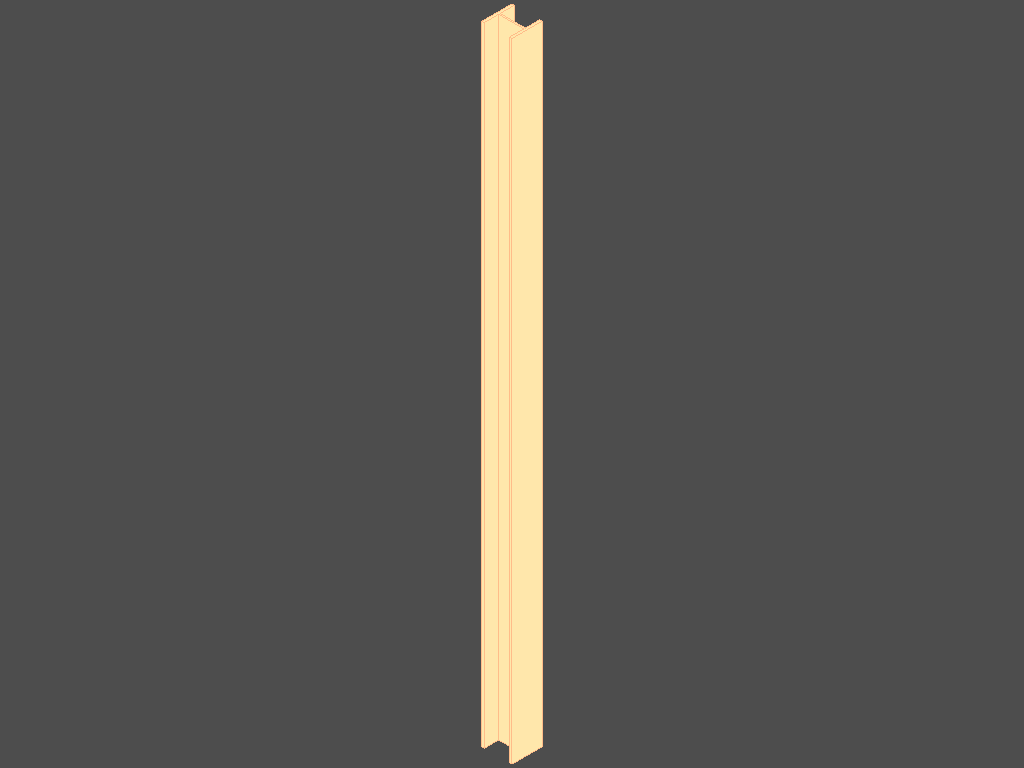

In [14]:
RenderImage(ElementsRenderFunc, elements={beam.GlobalId: beam})

### Display lines

In [15]:
beamCurves = getCurveShapes(beams)
print(len(beamCurves))
# columnCurves = getCurveShapes(columns)
curveShapes = [*beamCurves]

565


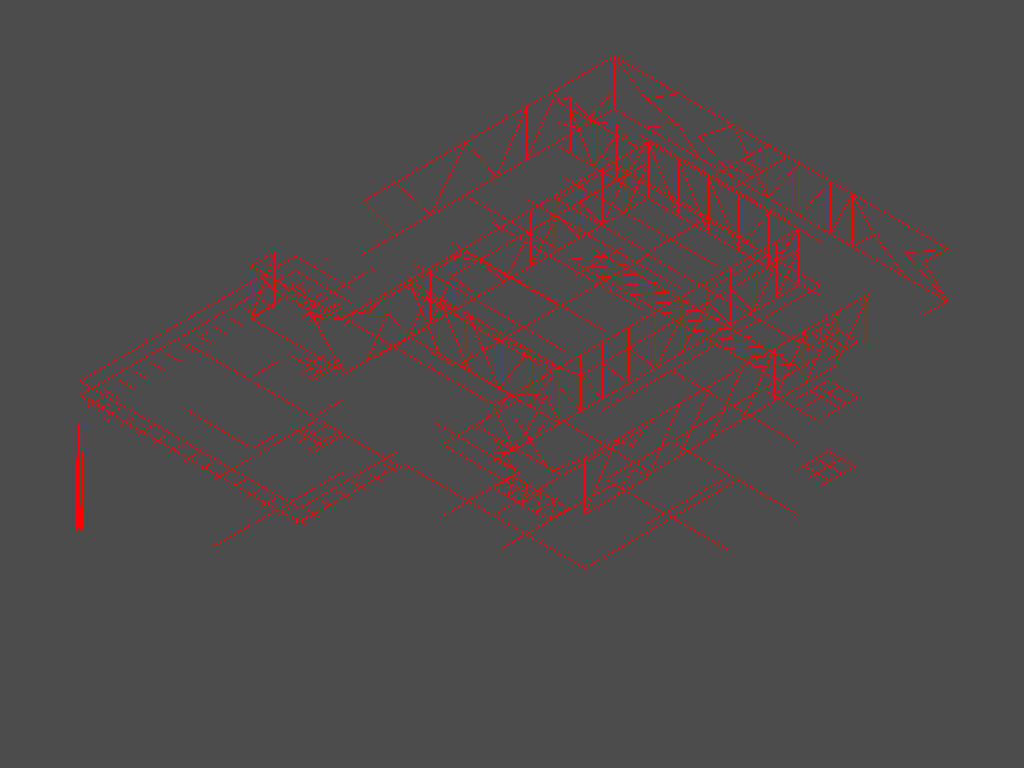

In [16]:
# RenderInWindow(SimpleRenderFunc, shapes=[curve.geometry for curve in curveShapes])
RenderImage(SimpleRenderFunc, shapes=[curve.geometry for curve in curveShapes])

### Display everything...

In [17]:
# elements = models['ark'].by_type('IfcBuildingElement')
elements = models['stru'].by_type('IfcBuildingElement')

In [18]:
def customRenderFunc(renderer, **args):
    elements = args['elements']
    elements_render = [elements[i] for i in range(1000)]
    
    for i, element in enumerate(elements_render):
        try:
            if (
                element.Representation is not None
            ):

                # body = ifcopenshell.util.representation.get_representation(element, "Model", "Body")
                # body_repr = ifcopenshell.util.representation.resolve_representation(body)
                # pdct_shape = ifcopenshell.geom.create_shape(settings, inst=element, repr=body_repr)

                pdct_shape = ifcopenshell.geom.create_shape(settings, inst=element)

                r, g, b, alpha = pdct_shape.styles[0]  # the shape color
                color = Quantity_Color(abs(r), abs(g), abs(b), Quantity_TOC_RGB)

                # print(f"pdct styles {len(pdct_shape.styles)}")

                # below, the pdct_shape.geometry is a TopoDS_Shape, i.e. can be rendered using
                # any renderer (threejs, x3dom, jupyter, qt5 based etc.)
                to_update = i % 50 == 0
                if True:
                    renderer.DisplayShape(
                        # pdct_shape.geometry, shape_color=color, transparency=True, opacity=alpha
                        pdct_shape.geometry,
                        # pdct_shape[1],
                        color=color,
                        transparency=abs(1 - alpha),
                        # transparency=alpha,
                        # transparency=0.7,
                        update=to_update,
                    )

                # Oriented bounding box
                if False:
                    elmShape = pdct_shape.geometry
                    obb = Bnd_OBB()
                    brepbndlib.AddOBB(elmShape, obb, True, True, True)
                    obb_shape = convert_bnd_to_shape(obb)
                    renderer.DisplayShape(obb_shape, color=rgb_color(1.0, 0.0, 1.0), transparency=0.8)

                    ais_line = convert_bnd_to_line(obb)


                    # lineSeg = GC_MakeSegment(pnt, pnt2).Value()
                    # ais_line = AIS_Line(lineSeg)


                    # pt1 = Geom_CartesianPoint(pnt)
                    # pt2 = Geom_CartesianPoint(pnt2)
                    # ais_line = AIS_Line(pt1, pt2)
                    # print(type(ais_line))
                    # print(type(z_dir))
                    # line = gp_Lin(pnt, z_dir)

                    # ais_pnt = AIS_Point(pnt)
                    # ais_line = ais_pnt
                    width = float(3.0)
                    drawer = ais_line.Attributes()
                    ais_line.SetWidth(width)

                    # asp : first parameter color, second type, last width
                    i = 1
                    asp = Prs3d_LineAspect(Quantity_Color(9 * i), i, width*5.0)
                    # drawer.SetLineAspect(asp)
                    # drawer.SetLineArrowDraw(True)
                    ais_line.SetAttributes(drawer)
                    # renderer.DisplayShape(ais_line)
                    renderer.Context.Display(ais_line, False)
                    # renderer.DisplayShape(pnt, color=rgb_color(0.0, 1.0, 0.0))
                    # renderer.DisplayShape(lineSeg, color=rgb_color(1.0, 1.0, 0.0))
                    # renderer.DisplayShape(pnt2, color=rgb_color(1.0, 1.0, 0.0))

            else:
                print(f"Product has no representation!, {element.get_info()}")

        except Exception as e:
            print(f"Error! {e}")
            print(f"Regarding element {element.get_info()}")


    # renderer.SetRaytracingMode(depth=4)
    renderer.FitAll()

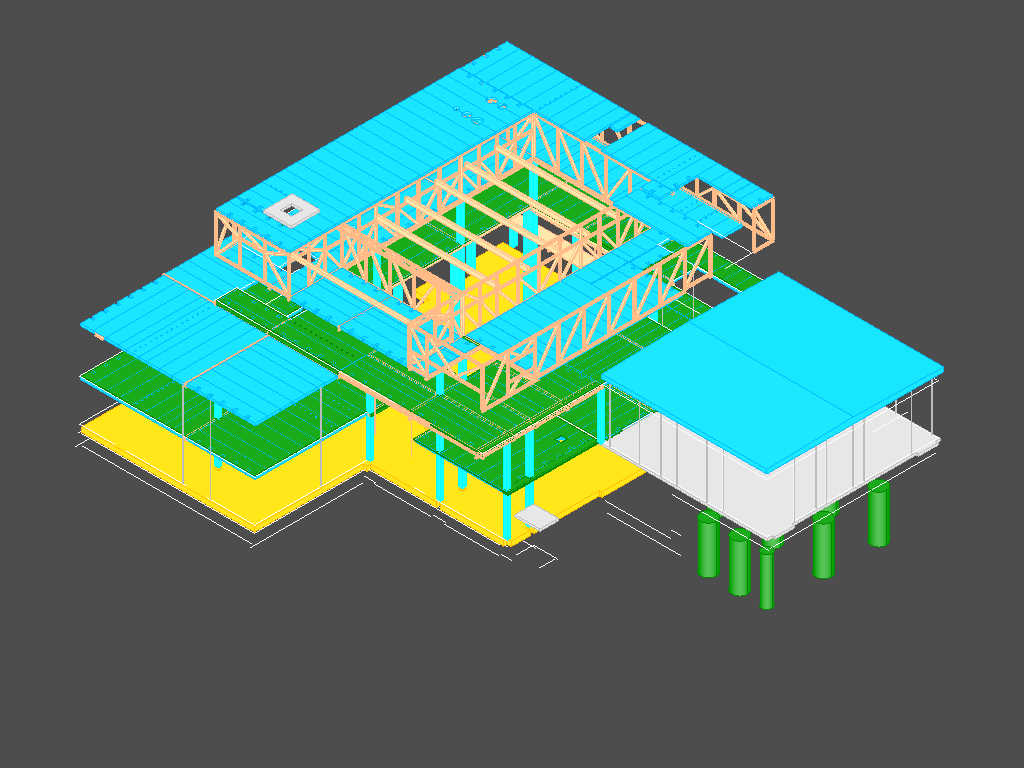

In [19]:
# RenderInWindow(customRenderFunc, elements=elements)
RenderImage(customRenderFunc, elements=elements)

In [20]:
model.by_type('IfcStructuralItem')

[]

In [21]:
model.by_type('IfcGroup')

[]

In [22]:
element = elements[0]
element

#180=IfcSlab('02OD1_RP5Akg$FG0k2tjDn',#18,'Floor:DS01:571984',$,'Floor:DS01',#131,#179,'571984',.FLOOR.)

In [23]:
model.traverse(element)

[#180=IfcSlab('02OD1_RP5Akg$FG0k2tjDn',#18,'Floor:DS01:571984',$,'Floor:DS01',#131,#179,'571984',.FLOOR.),
 #18=IfcOwnerHistory(#17,#2,$,.NOCHANGE.,$,$,$,1662038022),
 #17=IfcPersonAndOrganization(#15,#16,$),
 #15=IfcPerson($,'','ETA',$,$,$,$,$),
 #16=IfcOrganization($,'EKJ RÅDGIVENDE INGENIØRER AS','',$,$),
 #2=IfcApplication(#1,'2023','Autodesk Revit 2023 (ENU)','Revit'),
 #1=IfcOrganization($,'Autodesk Revit 2023 (ENU)',$,$,$),
 #131=IfcLocalPlacement(#112,#130),
 #112=IfcLocalPlacement(#96,#111),
 #96=IfcLocalPlacement(#123,#95),
 #123=IfcLocalPlacement($,#122),
 #122=IfcAxis2Placement3D(#3,$,$),
 #3=IfcCartesianPoint((0.,0.,0.)),
 #95=IfcAxis2Placement3D(#3,$,$),
 #111=IfcAxis2Placement3D(#110,$,$),
 #110=IfcCartesianPoint((0.,0.,8780.)),
 #130=IfcAxis2Placement3D(#3,$,$),
 #179=IfcProductDefinitionShape($,$,(#178)),
 #178=IfcShapeRepresentation(#88,'Body','SweptSolid',(#173)),
 #88=IfcGeometricRepresentationSubContext('Body','Model',*,*,*,*,#86,$,.MODEL_VIEW.,$),
 #86=IfcGeometri

## Example connections

### 3 steel beams, 1 steel column, corner

![](AdvBIM-A2_Analysis.ipynb_img/pasted_2023-10-20-11-28-53.png)

In [24]:
guids = [
    "1gWnGCa$TAouEuWitQnG6O",
    "1gWnGCa$TAouEuWitQnG8y",
    "1gWnGCa$TAouEuWitQnG5y",
    "1gWnGCa$TAouEuWitQnG6A",
    # "2RiPt4b_L7lu6usHtxHmZS", # IfcSlab above
    "1gWnGCa$TAouEuWitQnG5o", # Extras
    "1gWnGCa$TAouEuWitQnGB2",
]

In [25]:
elements = [model.by_guid(guid) for guid in guids]
elements

[#13918=IfcBeam('1gWnGCa$TAouEuWitQnG6O',#18,'H-Wide Flange Beams:SB30:1803556',$,'H-Wide Flange Beams:SB30',#13917,#13914,'1803556',.BEAM.),
 #20668=IfcBeam('1gWnGCa$TAouEuWitQnG8y',#18,'Rectangular and Square Hollow Sections:SB40:1803904',$,'Rectangular and Square Hollow Sections:SB40',#20667,#20664,'1803904',.BEAM.),
 #17051=IfcBeam('1gWnGCa$TAouEuWitQnG5y',#18,'H-Wide Flange Beams:SB30:1803712',$,'H-Wide Flange Beams:SB30',#17050,#17047,'1803712',.BEAM.),
 #14440=IfcBeam('1gWnGCa$TAouEuWitQnG6A',#18,'H-Wide Flange Beams:SB30:1803574',$,'H-Wide Flange Beams:SB30',#14439,#14436,'1803574',.BEAM.),
 #17256=IfcBeam('1gWnGCa$TAouEuWitQnG5o',#18,'H-Wide Flange Beams:SB30:1803726',$,'H-Wide Flange Beams:SB30',#17255,#17252,'1803726',.BEAM.),
 #20577=IfcBeam('1gWnGCa$TAouEuWitQnGB2',#18,'Rectangular and Square Hollow Sections:SB40:1803902',$,'Rectangular and Square Hollow Sections:SB40',#20576,#20573,'1803902',.BEAM.)]

In [26]:
def get_pdct_shape(element, settings):
    body = ifcopenshell.util.representation.get_representation(element, "Model", "Body")
    body_repr = ifcopenshell.util.representation.resolve_representation(body)
    pdct_shape = ifcopenshell.geom.create_shape(settings, inst=element, repr=body_repr)

    return pdct_shape

In [27]:
def get_OBB(elmShape):
    obb = Bnd_OBB()
    brepbndlib.AddOBB(elmShape, obb, True, True, True)

    return obb

In [28]:
def get_elementShapes(elements, settings):
    elements_shape = dict()

    for element in elements:
        pdct_shape = get_pdct_shape(element, settings)
        GUID = element.GlobalId

        elements_shape[GUID] = pdct_shape

    return elements_shape

In [29]:
def get_elementsOBB(elements_shape):
    elements_obb = dict()

    for GUID, pdct_shape in elements_shape.items():
        elmShape = pdct_shape.geometry
        obb = get_OBB(elmShape)
        
        # Enlarge
        # obb.Enlarge(0.01)

        elements_obb[GUID] = obb

    return elements_obb


In [30]:
def find_collisions(elements_obb):
    common_collisions = set()
    element_collisions = dict()
    for key, obb in elements_obb.items():
        collides_with = list()
        collisions = list()
        for key2, obb2 in elements_obb.items():
            collides = not obb.IsOut(obb2)

            if collides:
                collides_with.append(key2)
        
            if key == key2: continue
            collisions.append(key2)
        
        element_collisions[key] = collisions

        collides_with.sort()
        common_collisions.add(tuple(collides_with))

    return common_collisions, element_collisions

In [31]:
def renderElementsOBB(renderer, **args):
    elements_shape = args['elements_shape']
    elements_obb = args['elements_obb']

    for GUID, pdct_shape in elements_shape.items():
        try:

            r, g, b, alpha = pdct_shape.styles[0]  # the shape color
            color = Quantity_Color(abs(r), abs(g), abs(b), Quantity_TOC_RGB)

            renderer.DisplayShape(
                # pdct_shape.geometry, shape_color=color, transparency=True, opacity=alpha
                pdct_shape.geometry,
                # pdct_shape[1],
                color=color,
                transparency=abs(1 - alpha),
                # transparency=alpha,
                # transparency=0.7,
            )

        except Exception as e:
                print(f"Error! {e}")


    for GUID, obb in elements_obb.items():
        try:
            obb_shape = convert_bnd_to_shape(obb)
            renderer.DisplayShape(obb_shape, color=rgb_color(1.0, 0.0, 1.0), transparency=0.8)

            ais_line = convert_bnd_to_line(obb)

            width = float(3.0)
            drawer = ais_line.Attributes()
            ais_line.SetWidth(width)

            # asp : first parameter color, second type, last width
            i = 1
            asp = Prs3d_LineAspect(Quantity_Color(9 * i), i, width*5.0)
            # drawer.SetLineAspect(asp)
            # drawer.SetLineArrowDraw(True)
            ais_line.SetAttributes(drawer)
            renderer.Context.Display(ais_line, False)

        except Exception as e:
                print(f"Error! {e}")

    renderer.FitAll()

In [32]:
len(load_bearing)

1750

In [33]:
# elements = [load_bearing[i] for i in range(500)]
elements = load_bearing
len(elements)

1750

In [34]:
elements_shape = get_elementShapes(elements, settings)

In [35]:
elements_obb = get_elementsOBB(elements_shape)

In [36]:
common_collisions, element_collisions = find_collisions(elements_obb)

In [37]:
common_collisions = set([list(common_collisions)[i] for i in range(20)]) # Limit size for experiements...

In [38]:
len(common_collisions)

20

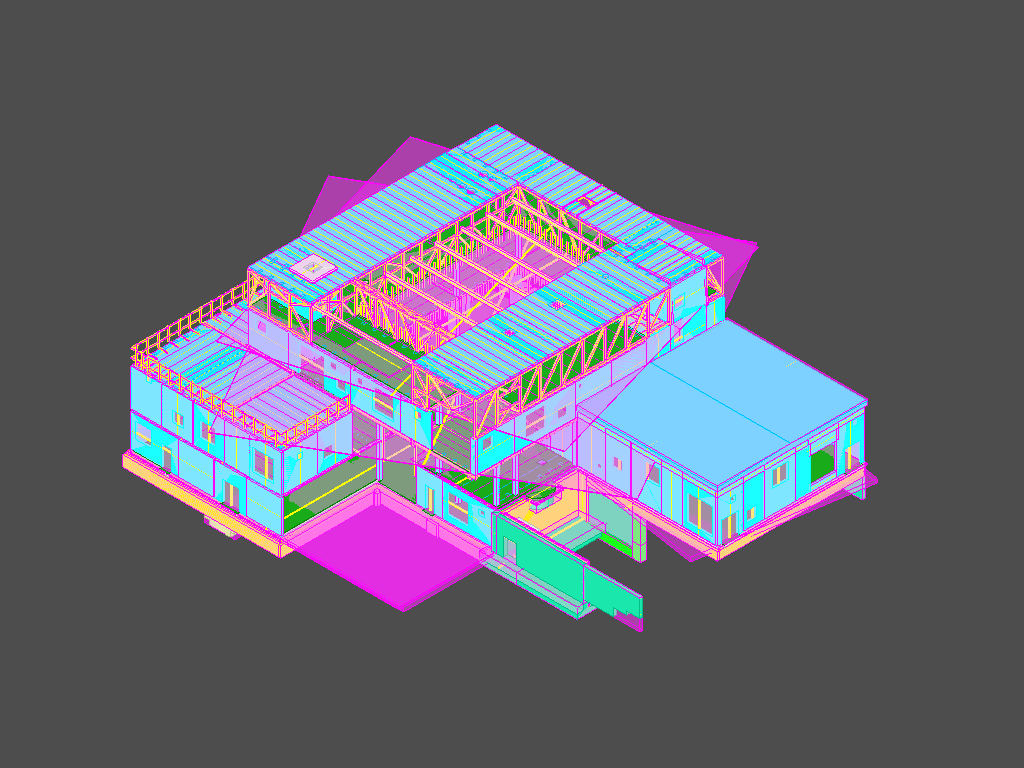

In [39]:
# RenderInWindow(renderElementsOBB, elements_shape=elements_shape, elements_obb=elements_obb)
RenderImage(renderElementsOBB, elements_shape=elements_shape, elements_obb=elements_obb)

In [40]:
collision_group_count = dict()
for collision_group in common_collisions:
    count = len(collision_group)
    
    if not collision_group_count.get(count):
        collision_group_count[count] = list()

    collision_group_count[count].append(collision_group)

[f"# {key } collisions: {len(val)}" for key, val in sorted(collision_group_count.items())]

['# 2 collisions: 1',
 '# 3 collisions: 4',
 '# 4 collisions: 3',
 '# 5 collisions: 4',
 '# 6 collisions: 1',
 '# 7 collisions: 3',
 '# 8 collisions: 1',
 '# 13 collisions: 1',
 '# 15 collisions: 1',
 '# 26 collisions: 1']

In [41]:
for col in common_collisions:
    print(col)

('0koPsDCuPDPuI8GznOjLD9', '0koPsDCuPDPuI8GzzOjLD9', '1jLRC8MWH8yhQO3uVKRx9q', '2YnN6LEU12WO1jZeWQ$aS4')
('0ixHINZ4LDwBbf9LgwLSfn', '1Z0U2jAgT1eh7MyZCtwjb7', '1Z0U2jAgT1eh7MyZCtwjii', '2T6nrlWL946e6n$TPEQQpg', '2T6nrlWL946e6n$TPEQQzL', '37c2TFAdTD9gP81smWIaO$', '37c2TFAdTD9gP81smWIaQj')
('0GbdI8LmT7OudkFj2hwgDY', '1z9uceUfrApQ_nV$si6y4x', '1z9uceUfrApQ_nV$wi6y4x', '3iqqCb9nXF_v6raZvUBQr5')
('00sM5Sj7j1aO0ymHEngBlU', '1Qqm_D40D5_AUMnhG8nIIi', '2Bbtc4Qtb4v9USChXqpWRZ', '3p$NKLd0XA4RQyc9xCjfx$', '3wlSLf7jr4DekjLTQJgz7k')
('0AnayT81z7qB5ugwu13RnS', '0IDasf2YDAAeSqCMzCxUiy', '0IDasf2YDAAeSqCMzCxUpg', '0ixHINZ4LDwBbf9LgwLSfn', '1PrzUAJXz5zRgyl4ul1i_Y', '1Yt5$Y0mXAFQTPL$ZSp14F', '1Yt5$Y0mXAFQTPL$ZSp14p', '1Yt5$Y0mXAFQTPL$ZSp15p', '1Yt5$Y0mXAFQTPL$ZSp17D', '1Yt5$Y0mXAFQTPL$ZSp17J', '1Yt5$Y0mXAFQTPL$ZSp17O', '1Yt5$Y0mXAFQTPL$ZSp17d', '1Yt5$Y0mXAFQTPL$ZSp17o', '1fdNgs4QH1PuqYzxfYQ1iK', '1z9uceUfrApQ_nT$_i6$Xd', '1zy7Tyf9f3FfQdDZgXIno$', '24LDybHFD3NxtBfY8PoJ44', '24LDybHFD3NxtBfY8PoJ7u', '2RSXRd

In [42]:
knots = set()
remove_knots = set()
for group in common_collisions:
    count = 0
    gknots = set()
    for GUID in group:
        obb = elements_obb[GUID]
        collisions = list()
        for GUID2 in group:
            # if GUID == GUID2: continue

            obb2 = elements_obb[GUID2]
            collides = not obb.IsOut(obb2)

            if collides:
                count += 1
                collisions.append(GUID2)

        # print(collisions)
        knots.add(tuple(collisions))
        gknots.add(tuple(collisions))

    print(gknots)
    for gknot in gknots:
        for gknot2 in gknots:
            if gknot == gknot2: continue

            if len(gknot) <= len(gknot2): continue

            if not gknot2 in gknot:
                print("Remove", gknot)
                remove_knots.add(gknot2)


    print(len(group), count)




{('0koPsDCuPDPuI8GznOjLD9', '1jLRC8MWH8yhQO3uVKRx9q', '2YnN6LEU12WO1jZeWQ$aS4'), ('0koPsDCuPDPuI8GznOjLD9', '0koPsDCuPDPuI8GzzOjLD9', '1jLRC8MWH8yhQO3uVKRx9q', '2YnN6LEU12WO1jZeWQ$aS4'), ('0koPsDCuPDPuI8GznOjLD9', '0koPsDCuPDPuI8GzzOjLD9', '2YnN6LEU12WO1jZeWQ$aS4')}
Remove ('0koPsDCuPDPuI8GznOjLD9', '0koPsDCuPDPuI8GzzOjLD9', '1jLRC8MWH8yhQO3uVKRx9q', '2YnN6LEU12WO1jZeWQ$aS4')
Remove ('0koPsDCuPDPuI8GznOjLD9', '0koPsDCuPDPuI8GzzOjLD9', '1jLRC8MWH8yhQO3uVKRx9q', '2YnN6LEU12WO1jZeWQ$aS4')
4 14
{('0ixHINZ4LDwBbf9LgwLSfn', '1Z0U2jAgT1eh7MyZCtwjb7', '1Z0U2jAgT1eh7MyZCtwjii', '2T6nrlWL946e6n$TPEQQpg', '2T6nrlWL946e6n$TPEQQzL', '37c2TFAdTD9gP81smWIaO$', '37c2TFAdTD9gP81smWIaQj'), ('0ixHINZ4LDwBbf9LgwLSfn', '1Z0U2jAgT1eh7MyZCtwjb7', '1Z0U2jAgT1eh7MyZCtwjii', '2T6nrlWL946e6n$TPEQQpg', '37c2TFAdTD9gP81smWIaO$'), ('0ixHINZ4LDwBbf9LgwLSfn', '2T6nrlWL946e6n$TPEQQpg', '2T6nrlWL946e6n$TPEQQzL', '37c2TFAdTD9gP81smWIaQj'), ('0ixHINZ4LDwBbf9LgwLSfn', '1Z0U2jAgT1eh7MyZCtwjb7', '2T6nrlWL946e6n$TPEQQpg', '3

In [43]:
remove_knots

{('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '2Bbtc4Qtb4v9USChXqpWRZ',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('029wE67P58RPBuGo6FsbBD',
  '0AnayT81z7qB5ugwu13Rv7',
  '1PrzUAJXz5zRgyl4ul1i_Y'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1Yt5$Y0mXAFQTPL$ZSp17o'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1Yt5$Y0mXAFQTPL$ZSp17o'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1Yt5$Y0mXAFQTPL$ZSp17D'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1Yt5$Y0mXAFQTPL$ZSp17D',
  '1Yt5$Y0mXAFQTPL$ZSp17o'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1PrzUAJXz5

In [44]:
knots

{('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '2Bbtc4Qtb4v9USChXqpWRZ',
  '3p$NKLd0XA4RQyc9xCjfx$',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '2Bbtc4Qtb4v9USChXqpWRZ',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('029wE67P58RPBuGo6FsbBD',
  '0AnayT81z7qB5ugwu13Rv7',
  '1PrzUAJXz5zRgyl4ul1i_Y'),
 ('029wE67P58RPBuGo6FsbBD',
  '0AnayT81z7qB5ugwu13Rv7',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1jdSxwd$L8NQ0XAgdAAlgI',
  '1p74GO18bEBgIxtEVkL_5N',
  '1qi89aVqvCRRthDWCeA1T0',
  '1qi89aVqvCRRthDWCeA1T9',
  '1qi89aVqvCRRthDWCeA1TI',
  '1qi89aVqvCRRthDWCeA1TR',
  '1z9uceUfrApQ_nT$_i6$Wh',
  '24LDybHFD3NxtBfY8PoJ44',
  '2RSXRd9ifA3gmmAuY_0rp0',
  '2RSXRd9ifA3gmmAuY_0rp9',
  '2RSXRd9ifA3gmmAuY_0rpV',
  '2RSXRd9ifA3gmmAuY_0rqo'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1Yt5$Y0mXAFQ

In [45]:
true_knots = remove_knots.intersection(knots)
true_knots

{('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '2Bbtc4Qtb4v9USChXqpWRZ',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('029wE67P58RPBuGo6FsbBD',
  '0AnayT81z7qB5ugwu13Rv7',
  '1PrzUAJXz5zRgyl4ul1i_Y'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1Yt5$Y0mXAFQTPL$ZSp17o'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1Yt5$Y0mXAFQTPL$ZSp17o'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1Yt5$Y0mXAFQTPL$ZSp17D'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1Yt5$Y0mXAFQTPL$ZSp17D',
  '1Yt5$Y0mXAFQTPL$ZSp17o'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1PrzUAJXz5

In [46]:
import copy

In [47]:
knots = set()
for group in common_collisions:
    count = 0
    print(group)
    for GUID in group:
        obb = elements_obb[GUID]
        collisions = list(tuple(copy.deepcopy(group)))
        for GUID2 in group:
            # if GUID == GUID2: continue

            obb2 = elements_obb[GUID2]
            collides = not obb.IsOut(obb2)
            # print(collides)
            if not collides:
                count += 1
                collisions.remove(GUID2)

        #print(collisions)
        knots.add(tuple(collisions))


    print(len(group), count)

knots


('0koPsDCuPDPuI8GznOjLD9', '0koPsDCuPDPuI8GzzOjLD9', '1jLRC8MWH8yhQO3uVKRx9q', '2YnN6LEU12WO1jZeWQ$aS4')
4 2
('0ixHINZ4LDwBbf9LgwLSfn', '1Z0U2jAgT1eh7MyZCtwjb7', '1Z0U2jAgT1eh7MyZCtwjii', '2T6nrlWL946e6n$TPEQQpg', '2T6nrlWL946e6n$TPEQQzL', '37c2TFAdTD9gP81smWIaO$', '37c2TFAdTD9gP81smWIaQj')
7 12
('0GbdI8LmT7OudkFj2hwgDY', '1z9uceUfrApQ_nV$si6y4x', '1z9uceUfrApQ_nV$wi6y4x', '3iqqCb9nXF_v6raZvUBQr5')
4 4
('00sM5Sj7j1aO0ymHEngBlU', '1Qqm_D40D5_AUMnhG8nIIi', '2Bbtc4Qtb4v9USChXqpWRZ', '3p$NKLd0XA4RQyc9xCjfx$', '3wlSLf7jr4DekjLTQJgz7k')
5 8
('0AnayT81z7qB5ugwu13RnS', '0IDasf2YDAAeSqCMzCxUiy', '0IDasf2YDAAeSqCMzCxUpg', '0ixHINZ4LDwBbf9LgwLSfn', '1PrzUAJXz5zRgyl4ul1i_Y', '1Yt5$Y0mXAFQTPL$ZSp14F', '1Yt5$Y0mXAFQTPL$ZSp14p', '1Yt5$Y0mXAFQTPL$ZSp15p', '1Yt5$Y0mXAFQTPL$ZSp17D', '1Yt5$Y0mXAFQTPL$ZSp17J', '1Yt5$Y0mXAFQTPL$ZSp17O', '1Yt5$Y0mXAFQTPL$ZSp17d', '1Yt5$Y0mXAFQTPL$ZSp17o', '1fdNgs4QH1PuqYzxfYQ1iK', '1z9uceUfrApQ_nT$_i6$Xd', '1zy7Tyf9f3FfQdDZgXIno$', '24LDybHFD3NxtBfY8PoJ44', '24LDybHFD3NxtBf

{('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '2Bbtc4Qtb4v9USChXqpWRZ',
  '3p$NKLd0XA4RQyc9xCjfx$',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '2Bbtc4Qtb4v9USChXqpWRZ',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('029wE67P58RPBuGo6FsbBD',
  '0AnayT81z7qB5ugwu13Rv7',
  '1PrzUAJXz5zRgyl4ul1i_Y'),
 ('029wE67P58RPBuGo6FsbBD',
  '0AnayT81z7qB5ugwu13Rv7',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1jdSxwd$L8NQ0XAgdAAlgI',
  '1p74GO18bEBgIxtEVkL_5N',
  '1qi89aVqvCRRthDWCeA1T0',
  '1qi89aVqvCRRthDWCeA1T9',
  '1qi89aVqvCRRthDWCeA1TI',
  '1qi89aVqvCRRthDWCeA1TR',
  '1z9uceUfrApQ_nT$_i6$Wh',
  '24LDybHFD3NxtBfY8PoJ44',
  '2RSXRd9ifA3gmmAuY_0rp0',
  '2RSXRd9ifA3gmmAuY_0rp9',
  '2RSXRd9ifA3gmmAuY_0rpV',
  '2RSXRd9ifA3gmmAuY_0rqo'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1Yt5$Y0mXAFQ

In [48]:
len(knots)

124

In [49]:
knots = [[*knot] for knot in knots]
knots

[['0koPsDCuPDPuI8GznOjLD9',
  '0koPsDCuPDPuI8GzzOjLD9',
  '1jLRC8MWH8yhQO3uVKRx9q',
  '2YnN6LEU12WO1jZeWQ$aS4'],
 ['0ixHINZ4LDwBbf9LgwLSfn',
  '1Z0U2jAgT1eh7MyZCtwjb7',
  '1Z0U2jAgT1eh7MyZCtwjii',
  '2T6nrlWL946e6n$TPEQQpg',
  '2T6nrlWL946e6n$TPEQQzL',
  '37c2TFAdTD9gP81smWIaO$',
  '37c2TFAdTD9gP81smWIaQj'],
 ['0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0IDasf2YDAAeSqCMzCxUpg',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1Yt5$Y0mXAFQTPL$ZSp17d',
  '1Yt5$Y0mXAFQTPL$ZSp17o',
  '1zy7Tyf9f3FfQdDZgXIno$',
  '2RSXRd9ifA3gmmAuY_0rqU'],
 ['0GbdI8LmT7OudkFj2hwgDY',
  '1z9uceUfrApQ_nV$si6y4x',
  '1z9uceUfrApQ_nV$wi6y4x',
  '3iqqCb9nXF_v6raZvUBQr5'],
 ['00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '2Bbtc4Qtb4v9USChXqpWRZ',
  '3p$NKLd0XA4RQyc9xCjfx$',
  '3wlSLf7jr4DekjLTQJgz7k'],
 ['1Qqm_D40D5_AUMnhG8nIIi',
  '2Bbtc4Qtb4v9USChXqpWRZ',
  '3wlSLf7jr4DekjLTQJgz7k'],
 ['0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0IDasf2YDAAeSqCMzCxUpg',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1PrzUAJXz5z

In [50]:
knots_set = set([tuple(sorted(knot)) for knot in knots])
knots_set

{('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '2Bbtc4Qtb4v9USChXqpWRZ',
  '3p$NKLd0XA4RQyc9xCjfx$',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '2Bbtc4Qtb4v9USChXqpWRZ',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('029wE67P58RPBuGo6FsbBD',
  '0AnayT81z7qB5ugwu13Rv7',
  '1PrzUAJXz5zRgyl4ul1i_Y'),
 ('029wE67P58RPBuGo6FsbBD',
  '0AnayT81z7qB5ugwu13Rv7',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1jdSxwd$L8NQ0XAgdAAlgI',
  '1p74GO18bEBgIxtEVkL_5N',
  '1qi89aVqvCRRthDWCeA1T0',
  '1qi89aVqvCRRthDWCeA1T9',
  '1qi89aVqvCRRthDWCeA1TI',
  '1qi89aVqvCRRthDWCeA1TR',
  '1z9uceUfrApQ_nT$_i6$Wh',
  '24LDybHFD3NxtBfY8PoJ44',
  '2RSXRd9ifA3gmmAuY_0rp0',
  '2RSXRd9ifA3gmmAuY_0rp9',
  '2RSXRd9ifA3gmmAuY_0rpV',
  '2RSXRd9ifA3gmmAuY_0rqo'),
 ('0AnayT81z7qB5ugwu13Ri7',
  '0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1Yt5$Y0mXAFQ

In [51]:
knots_keep = list()
for knot in knots_set:
    mask = [set([GUID in knot2 for GUID in knot]) for knot2 in knots_set]
    mask = [len(m) == 1 and list(m)[0] for m in mask]

    print(mask)
    print(mask.count(True))
    print(knot)
    # if mask.count(True) > 1:
    if mask.count(True) < len(knot):
        knots_keep.append(knot)

knots_keep

[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
1
('0koPsDCuPDPuI8GznOjLD9', '0koPsDCuPDPuI8GzzOjLD9', '1jLRC8MWH8yhQO3uVKRx9q', '2YnN6LEU12WO1jZeWQ$aS4')
[False, True, False, Fals

[('0koPsDCuPDPuI8GznOjLD9',
  '0koPsDCuPDPuI8GzzOjLD9',
  '1jLRC8MWH8yhQO3uVKRx9q',
  '2YnN6LEU12WO1jZeWQ$aS4'),
 ('0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0IDasf2YDAAeSqCMzCxUpg',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1Yt5$Y0mXAFQTPL$ZSp17d',
  '1Yt5$Y0mXAFQTPL$ZSp17o',
  '1zy7Tyf9f3FfQdDZgXIno$',
  '2RSXRd9ifA3gmmAuY_0rqU'),
 ('0ixHINZ4LDwBbf9LgwLSfn',
  '1Z0U2jAgT1eh7MyZCtwjb7',
  '1Z0U2jAgT1eh7MyZCtwjii',
  '2T6nrlWL946e6n$TPEQQpg',
  '2T6nrlWL946e6n$TPEQQzL',
  '37c2TFAdTD9gP81smWIaO$',
  '37c2TFAdTD9gP81smWIaQj'),
 ('0GbdI8LmT7OudkFj2hwgDY',
  '1z9uceUfrApQ_nV$si6y4x',
  '1z9uceUfrApQ_nV$wi6y4x',
  '3iqqCb9nXF_v6raZvUBQr5'),
 ('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '2Bbtc4Qtb4v9USChXqpWRZ',
  '3p$NKLd0XA4RQyc9xCjfx$',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0IDasf2YDAAeSqCMzCxUpg',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1Yt5$Y0mXAFQTPL$ZSp14F',
  '1Yt5$Y0mXAFQTPL$ZSp14p',
  '1Yt5$Y0mXAFQ

In [52]:
knots_keep = list()
for knot in knots_set:
    mask = [set([GUID in knot2 for GUID in knot]) for knot2 in knots_set]
    mask = [len(m) == 1 and list(m)[0] for m in mask]

    print(mask)
    print(mask.count(True), len(knot))
    print(knot, len(knot))
    # if mask.count(True) > 1:
    if mask.count(True) < len(knot):
        knots_keep.append(knot)

knots_keep

[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
1 4
('0koPsDCuPDPuI8GznOjLD9', '0koPsDCuPDPuI8GzzOjLD9', '1jLRC8MWH8yhQO3uVKRx9q', '2YnN6LEU12WO1jZeWQ$aS4') 4
[False, True, False, 

[('0koPsDCuPDPuI8GznOjLD9',
  '0koPsDCuPDPuI8GzzOjLD9',
  '1jLRC8MWH8yhQO3uVKRx9q',
  '2YnN6LEU12WO1jZeWQ$aS4'),
 ('0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0IDasf2YDAAeSqCMzCxUpg',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1Yt5$Y0mXAFQTPL$ZSp17d',
  '1Yt5$Y0mXAFQTPL$ZSp17o',
  '1zy7Tyf9f3FfQdDZgXIno$',
  '2RSXRd9ifA3gmmAuY_0rqU'),
 ('0ixHINZ4LDwBbf9LgwLSfn',
  '1Z0U2jAgT1eh7MyZCtwjb7',
  '1Z0U2jAgT1eh7MyZCtwjii',
  '2T6nrlWL946e6n$TPEQQpg',
  '2T6nrlWL946e6n$TPEQQzL',
  '37c2TFAdTD9gP81smWIaO$',
  '37c2TFAdTD9gP81smWIaQj'),
 ('0GbdI8LmT7OudkFj2hwgDY',
  '1z9uceUfrApQ_nV$si6y4x',
  '1z9uceUfrApQ_nV$wi6y4x',
  '3iqqCb9nXF_v6raZvUBQr5'),
 ('00sM5Sj7j1aO0ymHEngBlU',
  '1Qqm_D40D5_AUMnhG8nIIi',
  '2Bbtc4Qtb4v9USChXqpWRZ',
  '3p$NKLd0XA4RQyc9xCjfx$',
  '3wlSLf7jr4DekjLTQJgz7k'),
 ('0AnayT81z7qB5ugwu13RnS',
  '0IDasf2YDAAeSqCMzCxUiy',
  '0IDasf2YDAAeSqCMzCxUpg',
  '0ixHINZ4LDwBbf9LgwLSfn',
  '1PrzUAJXz5zRgyl4ul1i_Y',
  '1Yt5$Y0mXAFQTPL$ZSp14F',
  '1Yt5$Y0mXAFQTPL$ZSp14p',
  '1Yt5$Y0mXAFQ

In [53]:
print(len(common_collisions))
count = 2
collision_group = collision_group_count[count][0]

# collision_group = list(knots)[1]
collision_group = list(true_knots)[2]
elements_group = [model.by_guid(GUID) for GUID in collision_group]
len(elements_group)

20


6

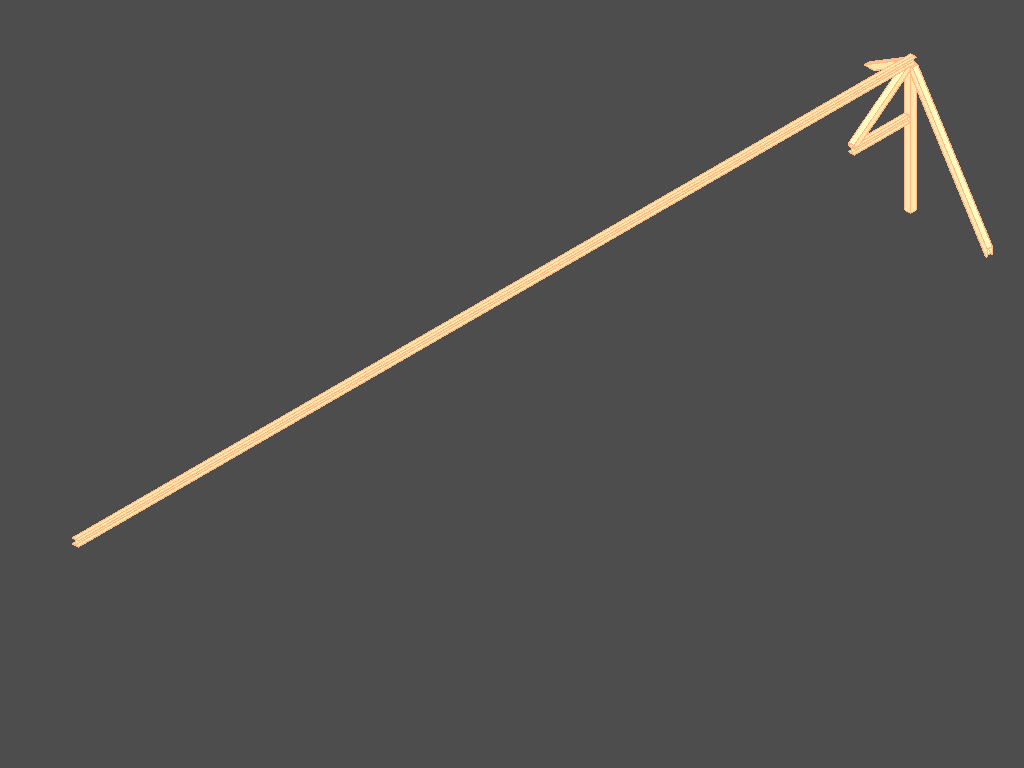

In [54]:
RenderImage(ElementsRenderFunc, elements={element.GlobalId: element for element in elements_group})

In [55]:
from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Common, BRepAlgoAPI_Section, BRepAlgoAPI_BooleanOperation
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeWedge

In [56]:
column = '1gWnGCa$TAouEuWitQnG6O'
beam1 = '1gWnGCa$TAouEuWitQnG8y' # Diagonal
beam2 = '1gWnGCa$TAouEuWitQnG5y'
beam3 = '1gWnGCa$TAouEuWitQnG6A' # Long

selected_guids = {
    column, beam1, beam2, beam3
}

selected_obb = {GUID: elements_obb.get(GUID) for GUID in selected_guids}
selected_shapes = {GUID: elements_shape.get(GUID) for GUID in selected_guids}

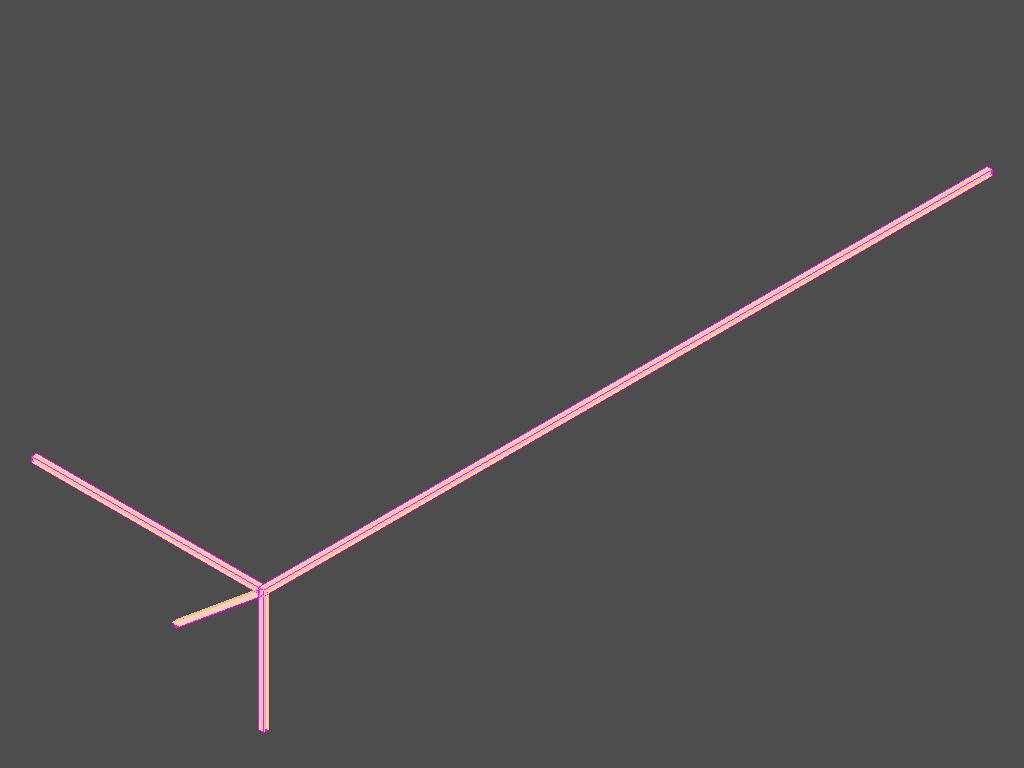

In [57]:
RenderImage(renderElementsOBB, elements_shape=selected_shapes, elements_obb=selected_obb)

In [58]:
# Create Box
# axe = gp_Ax2(gp_Pnt(10, 10, 10), gp_Dir(1, 2, 1))
# Box = BRepPrimAPI_MakeBox(axe, 60, 80, 100).Shape()
# # # Create wedge
# Wedge = BRepPrimAPI_MakeWedge(60.0, 100.0, 80.0, 20.0).Shape()
# Common surface


# Box = convert_bnd_to_shape(elements_obb[column])
# Wedge = convert_bnd_to_shape(elements_obb[beam3])


# Box = elements_obb[column]
# Wedge = elements_obb[beam1]

Box = elements_shape[column].geometry
Wedge = elements_shape[beam1].geometry

CommonSurface = BRepAlgoAPI_Common(Box, Wedge).Shape()

common_obb = get_OBB(CommonSurface)
common_obbShp = convert_bnd_to_shape(common_obb)

print(f"Box: {Box}")
print(f"Wedge: {Wedge}")
print(f"CommonSurface: {CommonSurface}")
print(f"Common_obb: {common_obb}")
print(f"Common_obbShp: {common_obbShp}")

Box: <class 'TopoDS_Compound'>
Wedge: <class 'TopoDS_Compound'>
CommonSurface: <class 'TopoDS_Compound'>
Common_obb: <class 'Bnd_OBB'>
Common_obbShp: <class 'TopoDS_Solid'>


In [59]:
from OCC.Core.Bnd import Bnd_Box

In [60]:
def FitToShape(occ_display, shape, enlarge=0.02):
    bbox = Bnd_Box()
    brepbndlib.Add(shape, bbox)
    
    bbox.Enlarge(enlarge)

    diag = bbox.SquareExtent() ** 0.5
    occ_display.View.FitAll(bbox, diag)

    bboxShp = BRepPrimAPI_MakeBox(bbox.CornerMin(), bbox.CornerMax()).Shape()

    return bbox, bboxShp

In [61]:
def renderFunc(renderer, **args):
    
    try:
        renderer.EraseAll()
        ais_box = renderer.DisplayShape(Box)[0]
        ais_wedge = renderer.DisplayShape(Wedge)[0]
        renderer.Context.SetTransparency(ais_box, 0.8, True)
        renderer.Context.SetTransparency(ais_wedge, 0.8, True)
        renderer.DisplayShape(common_obbShp, color=rgb_color(0.0, 1.0, 1.0), transparency=0.5)
        renderer.DisplayShape(CommonSurface, color=rgb_color(1.0, 0.0, 1.0),transparency=0.5)    
        
        bbox, bboxShp = FitToShape(renderer, common_obbShp)
        # renderer.DisplayShape(bboxShp, color=rgb_color(0.0, 1.0, 0.0),transparency=0.5)

        # renderer.SetModeWireFrame()
        # renderer.FitAll()

    except Exception as e:
        print(f"Exception!: {e}")

    print(args)


{'testarg': 'abc'}


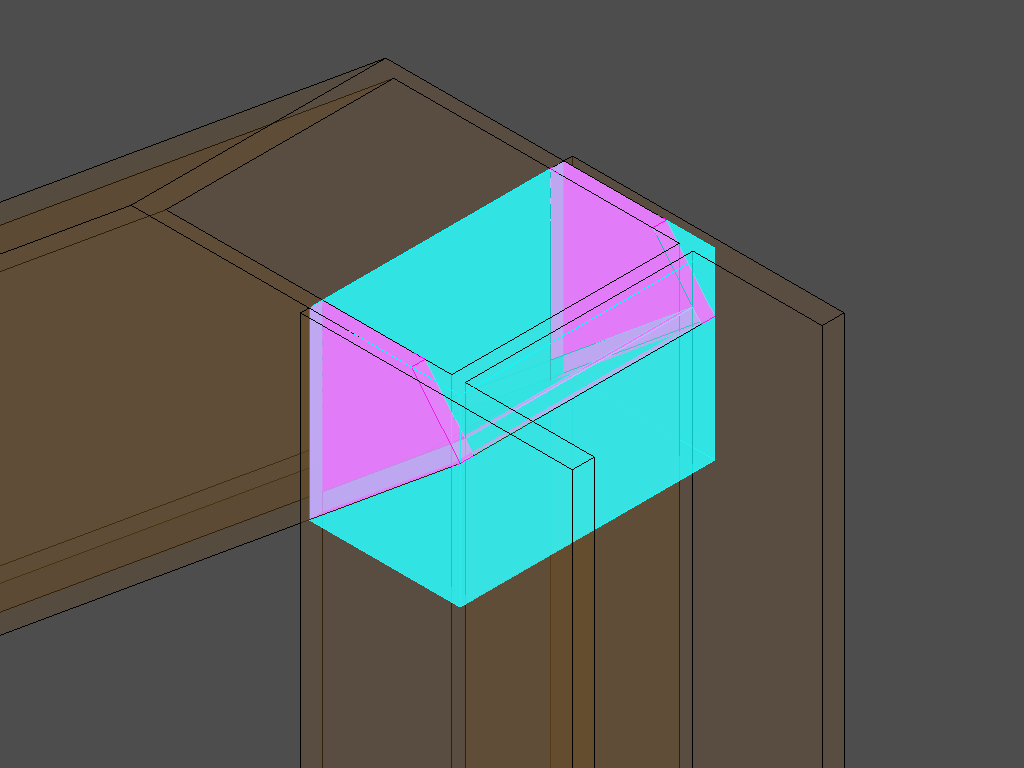

In [62]:
RenderImage(renderFunc,  testarg='abc')

**Tests**...:

In [63]:
import multiprocessing
tree = ifcopenshell.geom.tree()
iterator = ifcopenshell.geom.iterator(settings, model, multiprocessing.cpu_count())
if iterator.initialize():
    while True:
        tree.add_element(iterator.get_native())
        if not iterator.next():
            break

In [64]:
beam = model.by_guid(guids[0])
beam

#13918=IfcBeam('1gWnGCa$TAouEuWitQnG6O',#18,'H-Wide Flange Beams:SB30:1803556',$,'H-Wide Flange Beams:SB30',#13917,#13914,'1803556',.BEAM.)

In [65]:
elements = tree.select_box(beam, extend=0.001)
elements

[#12571=IfcBeam('1gWnGCa$TAouEuWitQnG1a',#18,'Rectangular and Square Hollow Sections:SB40:1803480',$,'Rectangular and Square Hollow Sections:SB40',#12570,#12567,'1803480',.BEAM.),
 #13918=IfcBeam('1gWnGCa$TAouEuWitQnG6O',#18,'H-Wide Flange Beams:SB30:1803556',$,'H-Wide Flange Beams:SB30',#13917,#13914,'1803556',.BEAM.),
 #17256=IfcBeam('1gWnGCa$TAouEuWitQnG5o',#18,'H-Wide Flange Beams:SB30:1803726',$,'H-Wide Flange Beams:SB30',#17255,#17252,'1803726',.BEAM.),
 #14440=IfcBeam('1gWnGCa$TAouEuWitQnG6A',#18,'H-Wide Flange Beams:SB30:1803574',$,'H-Wide Flange Beams:SB30',#14439,#14436,'1803574',.BEAM.),
 #17051=IfcBeam('1gWnGCa$TAouEuWitQnG5y',#18,'H-Wide Flange Beams:SB30:1803712',$,'H-Wide Flange Beams:SB30',#17050,#17047,'1803712',.BEAM.),
 #20668=IfcBeam('1gWnGCa$TAouEuWitQnG8y',#18,'Rectangular and Square Hollow Sections:SB40:1803904',$,'Rectangular and Square Hollow Sections:SB40',#20667,#20664,'1803904',.BEAM.),
 #17256=IfcBeam('1gWnGCa$TAouEuWitQnG5o',#18,'H-Wide Flange Beams:SB30:1

In [66]:
project = model.by_type('IfcProject')[0]
project

#93=IfcProject('3yHhRiYMfCAOAtv2MmnXRn',#18,'17-0279',$,$,'LLYN.B374','AS BUILT',(#86,#91),#82)

In [67]:
project.UnitsInContext

#82=IfcUnitAssignment((#19,#21,#22,#26,#27,#30,#31,#33,#34,#35,#37,#40,#42,#46,#47,#48,#49,#50,#51,#52,#53,#54,#55,#60,#62,#64,#67,#68,#69,#70,#71,#72,#73,#74,#76,#77,#78,#79,#80,#81))

In [68]:
ifcopenshell.util.unit.get_project_unit(model, 'LENGTHUNIT')

#19=IfcSIUnit(*,.LENGTHUNIT.,.MILLI.,.METRE.)

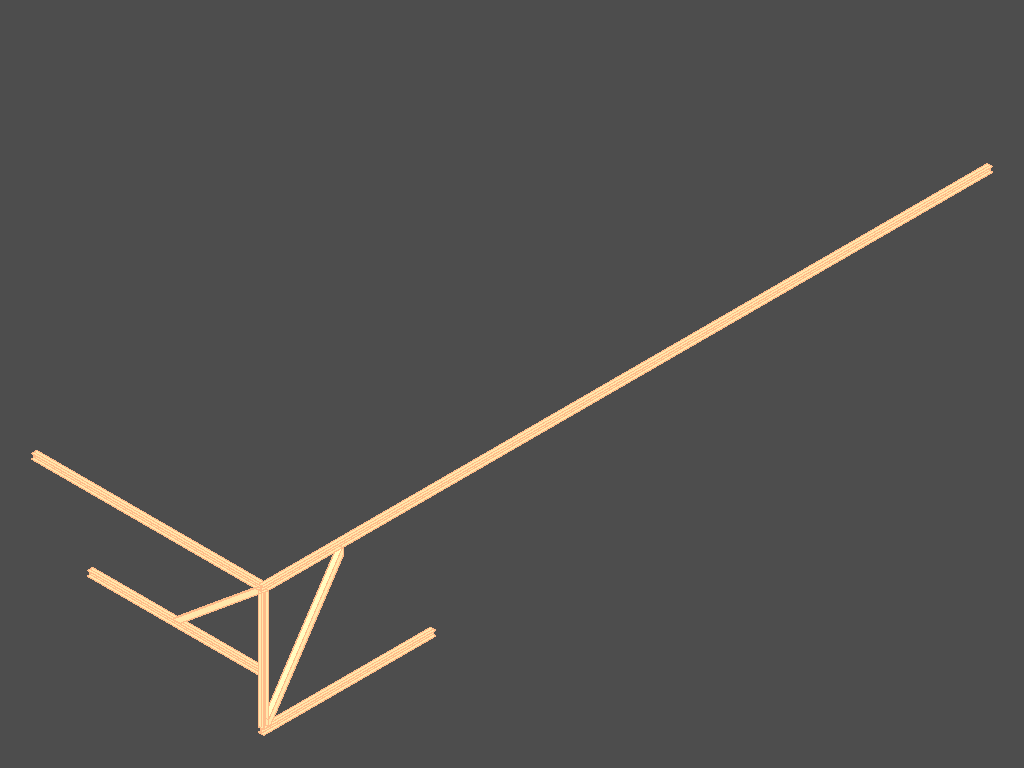

In [69]:
RenderImage(ElementsRenderFunc, elements={element.GlobalId: element for element in elements})

In [70]:
tree.select((0.0,1.0,0.0), extend=1.0)

[#30711=IfcWall('1y5zR70q9Ei91j17LgWJjD',#18,'Basic Wall:VE20-0:2141291',$,'Basic Wall:VE20-0',#30684,#30710,'2141291',.NOTDEFINED.),
 #30811=IfcWall('2jLI9K8E5EMw$NqVQCu6VH',#18,'Basic Wall:VE20-0:2145372',$,'Basic Wall:VE20-0',#30780,#30810,'2145372',.NOTDEFINED.),
 #6527=IfcWall('3T6FHmWKb6ZvXDr7YUs9wh',#18,'Basic Wall:FSS20:1208520',$,'Basic Wall:FSS20',#6512,#6526,'1208520',.NOTDEFINED.),
 #7225=IfcWall('0eZERX1xzDug5ZdIa0w5J6',#18,'Basic Wall:FSS20:1307796',$,'Basic Wall:FSS20',#7213,#7224,'1307796',.NOTDEFINED.),
 #7225=IfcWall('0eZERX1xzDug5ZdIa0w5J6',#18,'Basic Wall:FSS20:1307796',$,'Basic Wall:FSS20',#7213,#7224,'1307796',.NOTDEFINED.),
 #5368=IfcWall('1jLRC8MWH8yhQO3uVKRzKM',#18,'Basic Wall:FS50:1090729',$,'Basic Wall:FS50',#5353,#5367,'1090729',.NOTDEFINED.),
 #49686=IfcWall('2OpXq0uIfC6egnlWE2fkHp',#18,'Basic Wall:IH25:2545696',$,'Basic Wall:IH25',#49667,#49685,'2545696',.NOTDEFINED.),
 #6527=IfcWall('3T6FHmWKb6ZvXDr7YUs9wh',#18,'Basic Wall:FSS20:1208520',$,'Basic Wall:FSS

In [71]:
guids

['1gWnGCa$TAouEuWitQnG6O',
 '1gWnGCa$TAouEuWitQnG8y',
 '1gWnGCa$TAouEuWitQnG5y',
 '1gWnGCa$TAouEuWitQnG6A',
 '1gWnGCa$TAouEuWitQnG5o',
 '1gWnGCa$TAouEuWitQnGB2']

Length of list: 6


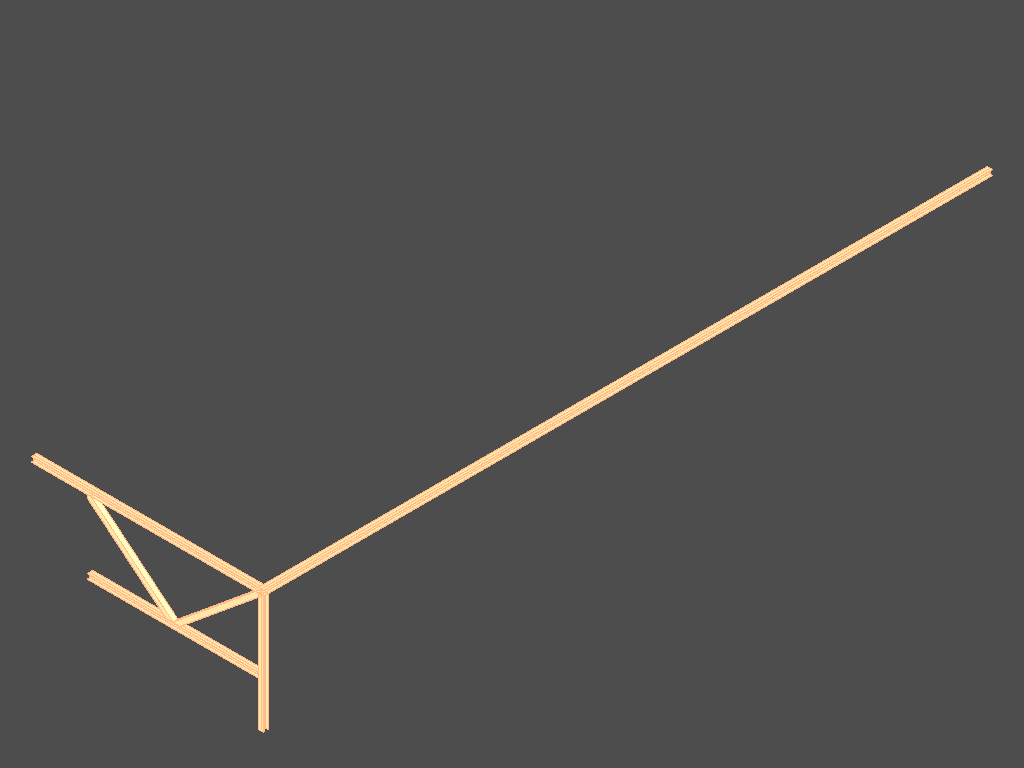

In [72]:
elements_render = utils.getElementsRender(guids, model)
RenderImage(ElementsRenderFunc, elements={element.GlobalId: element for element in elements_render})

### 3 steel beams, middle of beam

![](AdvBIM-A2_Analysis.ipynb_img/pasted_2023-10-20-11-30-59.png)

In [73]:
guids = [
    "1gWnGCa$TAouEuWitQnG5o",
    "1gWnGCa$TAouEuWitQnG8y",
    "1gWnGCa$TAouEuWitQnGB2",
]

Length of list: 3


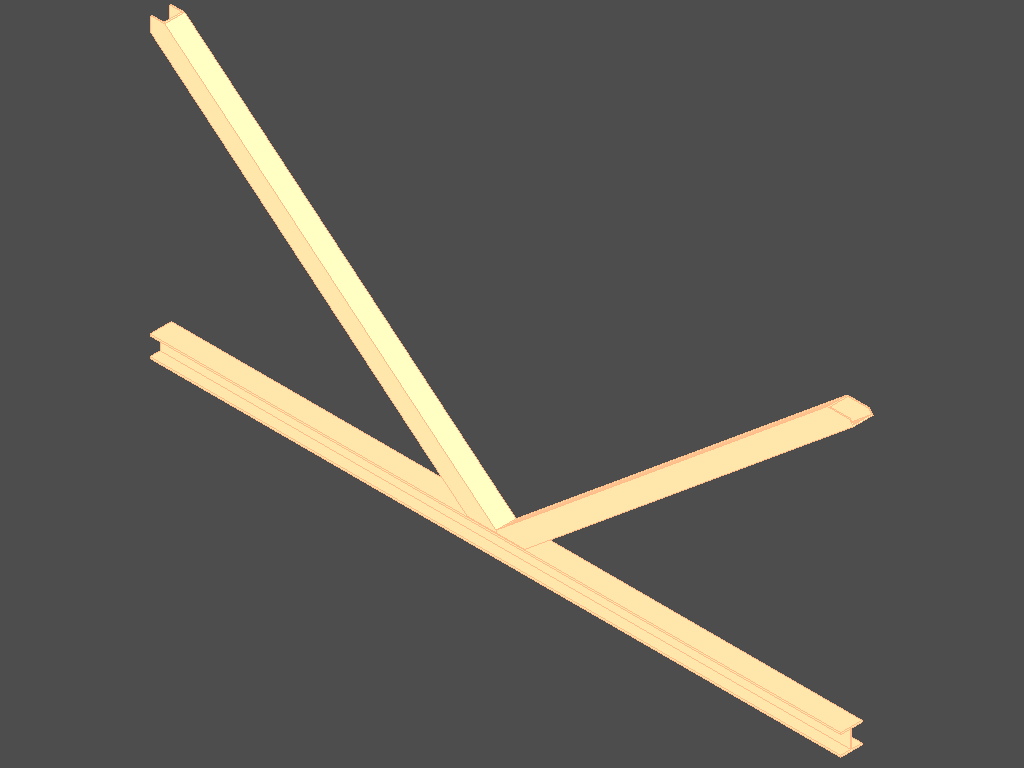

In [74]:
elements_render = utils.getElementsRender(guids, model)
RenderImage(ElementsRenderFunc, elements={element.GlobalId: element for element in elements_render})